### This is a notebook for running spatial analysis on paired FOVs and cell tables generated via the `Segment_Image_Data.ipynb` notebook.

In [1]:
# Import all the necessary packages
import os
import xarray as xr
import numpy as np
import pandas as pd

from ark.utils import spatial_analysis_utils, io_utils, plot_utils, load_utils
from ark.analysis import spatial_analysis, visualize

import ark.settings as settings

In [2]:
# This script takes a cell expression matrix, label maps for the fovs to be included in the analysis, and, depending
# on the analysis, a threshold matrix for channel or cluster spatial analysis. In channel spatial analysis, cells for
# a specific fov are identified, and cells of particular phenotypes are compared to each other to check for positive,
# negative, or no enrichment. To do this, a distance matrix is created from the label_maps, cell phenotypes are
# identified by their labels in the image and then significant interactions between different populations of phenotypes
# are recorded. Similar analysis is also done for channel spatial enrichment; however, instead of looking at cell
# phenotypes, markers positive for specific thresholds are identified and specific interactions are then characterized
# between them.

In [3]:
# Set up file paths and import data
base_dir = "../data/example_dataset/"
spatial_analysis_dir = os.path.join(base_dir, "spatial_enrichment_input_data")
deepcell_output = os.path.join(spatial_analysis_dir, "deepcell_output")

In [4]:
# validate file paths (add other directories as needed)
io_utils.validate_paths([
    base_dir,
    spatial_analysis_dir,
    deepcell_output,
])

### Loading in generated cell tables from csv file

In [5]:
# Import the necessary data
# This is the cell expression matrix including data for fovs 6 and 7, their cell labels, marker expression,
# cell phenotypes, and cell phenotype IDs.
all_data = pd.read_csv(os.path.join(spatial_analysis_dir, "example_expression_matrix.csv"))

### Loading user specified marker thresholds from csv file

If you're only trying to look at cluster based spatial analysis, you may skip this step.

Support for programmatic generation of marker thresholds may be available in the future.

In [6]:
# This is the threshold matrix with all marker thresholds - for channel cpatial enrichment
marker_thresholds = pd.read_csv(os.path.join(spatial_analysis_dir, "markerThresholds.csv"))
marker_thresholds = marker_thresholds.drop(0, axis=0)

### Loading in segmentation labels and constructing distance matrices

If you're using the legacy `.xr` data format, you will have to load in the file via:
```
label_maps = xr.load_dataarray(path_to_file)
```

In [7]:
# This is the Xarray of label maps for multiple fovs from which the distance matrix will be computed
#label_maps = xr.load_dataarray(os.path.join(spatial_analysis_dir, "segmentation_labels.xr"))
label_maps = load_utils.load_imgs_from_dir(deepcell_output, xr_channel_names=['segmentation_label'], trim_suffix='_feature_0')

# Get dictionary object with the respective distance matrices for the fovs
dist_mats = spatial_analysis_utils.calc_dist_matrix(label_maps)

### Channels excluded from spatial analysis

These will generally be non biologically significant channels, or channels which won't posess
interesting spatial distribution

In [8]:
excluded_channels = [
    "C",
    "Na",
    "Si",
    "Background",
    "HH3",
    "Ta",
    "Au",
]

### Compute spatial enrichment for channel expression in cells

If you're not interested in channel expression, or don't have marker thresholds, continue to the
below step.

In [9]:
values_channel, stats_channel = spatial_analysis.calculate_channel_spatial_enrichment(
    dist_mats, marker_thresholds, all_data, excluded_channels, bootstrap_num=5)

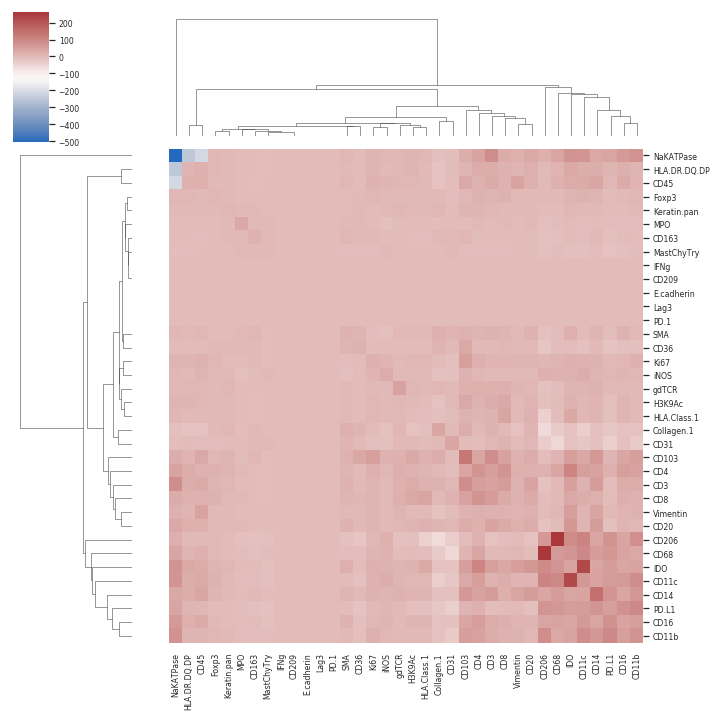

In [10]:
# For channel spatial analysis, first find all the marker titles to use as input for the clustergram
channel_start = np.where(all_data.columns == settings.PRE_CHANNEL_COL)[0][0] + 1
channel_end = np.where(all_data.columns == settings.POST_CHANNEL_COL)[0][0]

marker_titles = all_data.iloc[:, channel_start:channel_end].drop(excluded_channels, axis=1).columns
visualize.draw_heatmap(stats_channel.loc['fov6', "z", :, :].values, marker_titles, marker_titles)

### Compute spatial enrichment for cluster identity of cells

If you don't have cluster data, skip this step.  A cell clustering notebook will be released
shortly to fascilitate this step.

In [11]:
values_cluster, stats_cluster = spatial_analysis.calculate_cluster_spatial_enrichment(
    all_data, dist_mats, bootstrap_num=5)

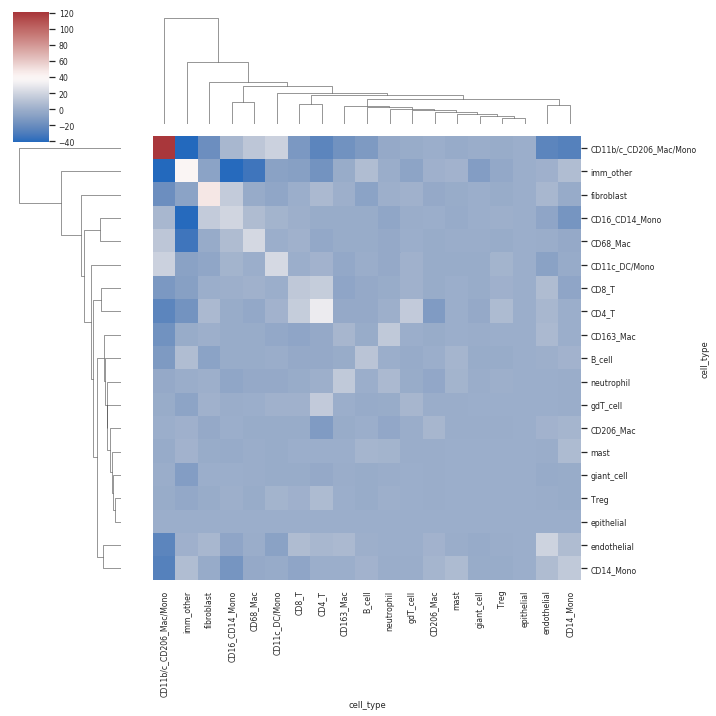

In [12]:
# To visualize the z scores, a clustermap can be produced
# For cluster spatial analysis, first find all the cell phenotypes in the data to use as an input for the clustergram
pheno_titles = all_data["cell_type"].drop_duplicates()
visualize.draw_heatmap(stats_cluster.loc['fov6', "z", :, :].values, pheno_titles, pheno_titles)